<h1> <center> GEOG 172: INTERMEDIATE GEOGRAPHICAL ANALYSIS </h1>
    <h2> <center> Evgeny Noi </h2>
        <h3> <center> Lecture 15: Linear Regression </h3>

# Correction  

#### The optimal number of clusters on this plot is 3! (The closer to +1 the better). 

<img src="sil_plot.PNG">

# Announcements 

* No labs this week (STRIKE) 
* Extended office hours (M:2-6pm, W:1-3pm) 
* Interim report due **W: midnight**

# Correlation Refresher 

* Correlation - is linear relationship between two variables (bivariate). 
* Standardized measure (+1 / -1)
* Slope of the line between scatter points on a scatter plot 

# Different Ways to Understand Regression 

* Fancy correlation 
* Optimization problem 
* statistical framework for modeling 

In [1]:
!python -m wget https://geographicdata.science/book/_downloads/dcd429d1761a2d0efdbc4532e141ba14/regression_db.geojson


Saved under regression_db (1).geojson


In [2]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt 
import seaborn as sns
import pingouin as pg

C:\Users\noibar\anaconda3\envs\geo_env\lib\site-packages\outdated\utils.py:14: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.1, the latest is 0.2.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


In [3]:
db = gpd.read_file("regression_db.geojson")
print(db.shape) 
db.head()

(6110, 20)


,accommodates,bathrooms,bedrooms,beds,neighborhood,pool,d2balboa,coastal,price,log_price,id,pg_Apartment,pg_Condominium,pg_House,pg_Other,pg_Townhouse,rt_Entire_home/apt,rt_Private_room,rt_Shared_room,geometry
0,5,2.0,2.0,2.0,North Hills,0,2.972077,0,425.0,6.052089,6,0,0,1,0,0,1,0,0,POINT (-117.12971 32.75399)
1,6,1.0,2.0,4.0,Mission Bay,0,11.501385,1,205.0,5.323010,5570,0,1,0,0,0,1,0,0,POINT (-117.25253 32.78421)
2,2,1.0,1.0,1.0,North Hills,0,2.493893,0,99.0,4.595120,9553,1,0,0,0,0,0,1,0,POINT (-117.14121 32.75327)
3,2,1.0,1.0,1.0,Mira Mesa,0,22.293757,0,72.0,4.276666,14668,0,0,1,0,0,0,1,0,POINT (-117.15269 32.93110)
4,2,1.0,1.0,1.0,Roseville,0,6.829451,0,55.0,4.007333,38245,0,0,1,0,0,0,1,0,POINT (-117.21870 32.74202)


In [4]:
variable_names = [
    "accommodates",  # Number of people it accommodates
    "bathrooms",  # Number of bathrooms
    "bedrooms",  # Number of bedrooms
    "beds",  # Number of beds
    # Below are binary variables, 1 True, 0 False
    "rt_Private_room",  # Room type: private room
    "rt_Shared_room",  # Room type: shared room
    "pg_Condominium",  # Property group: condo
    "pg_House",  # Property group: house
    "pg_Other",  # Property group: other
    "pg_Townhouse",  # Property group: townhouse
]

# How do we do analysis on this data? 

1. Visualize 
2. Run pairwise correlations 
3. Run Global Moran's I (and local if necessary) 
4. Run clustering (to investigate any patterns in multivariate data)
5. **RUN REGRESSION** (today) 

In [5]:
fig, ax = plt.subplots(figsize=(7,7))
sns.heatmap(db.corr(), annot=True, ax=ax, 
            fmt=".1f", annot_kws={"size": 8}, 
           cmap='vlag', vmin=db.corr().min().min(), vmax=db.corr().max().max());
#plt.gcf().subplots_adjust(left=0.15)
fig.savefig('corr_matrix.png', bbox_inches='tight') 
plt.close()

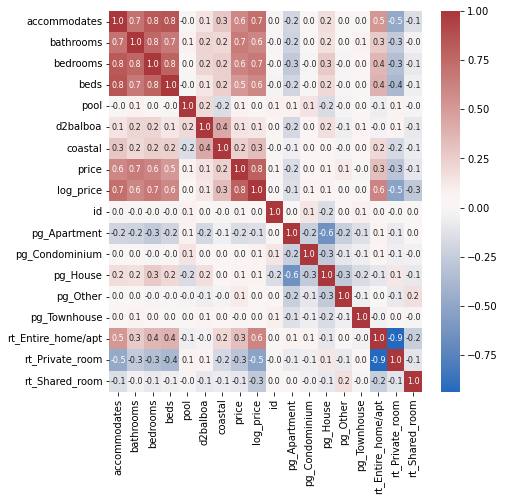

In [6]:
from IPython.display import Image
Image(filename='corr_matrix.png') 

In [7]:
# now the same with the table 
db_corr = pg.pairwise_corr(db, method='pearson').sort_values(by='r')
db_corr.loc[(db_corr.X == 'log_price')|(db_corr.Y == 'log_price'), ['X', 'Y', 'r', 'p-unc']]

,X,Y,r,p-unc
115,log_price,rt_Private_room,-0.525523,0.000000e+00
116,log_price,rt_Shared_room,-0.277179,3.452531e-108
109,log_price,pg_Apartment,-0.140333,3.004493e-28
113,log_price,pg_Townhouse,0.005033,6.940470e-01
108,log_price,id,0.015802,2.168407e-01
65,pool,log_price,0.018576,1.465442e-01
112,log_price,pg_Other,0.031385,1.415184e-02
111,log_price,pg_House,0.073500,8.828480e-09
110,log_price,pg_Condominium,0.074952,4.469152e-09
77,d2balboa,log_price,0.132289,2.927701e-25


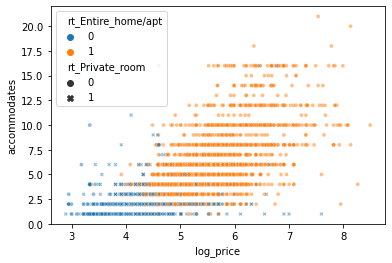

In [8]:
fig, ax = plt.subplots() 
sns.scatterplot(data=db, x='log_price', y='accommodates', ax=ax, 
                hue='rt_Entire_home/apt', alpha=.5, s=15, 
               style='rt_Private_room');

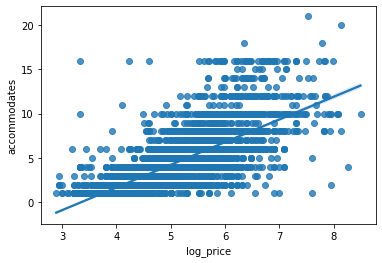

In [9]:
fig, ax = plt.subplots() 
sns.regplot(data=db, x='log_price', y='accommodates', ax=ax);

# Regression 

> Finding the best fitting line for the set of points (2d case) - GEOMETRIC SENSE!

#### Regression implies modeling **dependent** variable (outcome) using one or more **independent** variables (predictors) 

# The Modeling (statistical) Framework 

* outcome - price of AirBnb in San Diego, predictors - # of bedrooms, bathrooms, type of property, etc. 

> We are trying to explain 'variance' in the outcome by 'variance' in predictors

# Combining statistical + geometric framework 

$$
\hat{Y_i} = b_0 + b_1 X_i + \epsilon_i
$$

where $\hat{Y_i}$ denotes our prediction (line), $X_i$ predictor variable value for $i$th observations, $\beta_0$ is the intercept, and $\beta_1$ is the regression coefficient. And $\epsilon_i = \hat{Y_i} - Y_i$ (residuals/errors = predicted - actual values). 

<img src="https://ethanweed.github.io/pythonbook/_images/05.04-regression_12_0.png">

# Geometry + Optimization

* We want our combined $\epsilon$ (error/residuals) to be as small as possible. 

> The estimated regression coefficients $\hat{\beta_0}$ and $\hat{\beta_1}$ are those that **minimise the sum of the squared residuals** 

$$
\sum_i (Y_i - \hat{Y}_i)^2
$$

In [10]:
mod1 = pg.linear_regression(db['accommodates'], db['log_price'])
mod1

,names,coef,se,T,pval,r2,adj_r2,CI[2.5%],CI[97.5%]
0,Intercept,4.123498,0.012696,324.794585,0.0,0.528936,0.528859,4.098610,4.148386
1,accommodates,0.206661,0.002495,82.815413,0.0,0.528936,0.528859,0.201769,0.211553


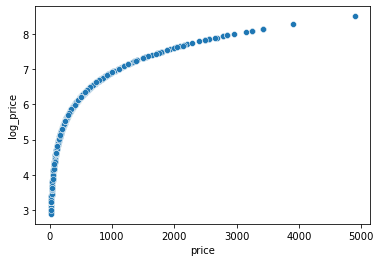

In [11]:
sns.scatterplot(data=db, x='price', y='log_price');

# Understanding Regression Equation 

$$
\hat{Y}_i = b_0 + b_1 X_i = 4.1 + 0.2 \ X_i  
$$

> For 1-unit increase in the number of people that the Airbnb property accommodates, we expect the log(price) to go up by .2

> The expected value of $\hat{Y_i}$ when $X_i = 0$ is 4.1

# Caution ⚠️

#### Order in regression matters (typically, predictor goes first and outcome goes second)! We are modeling the log(price) as a function of the number of people that the apartment from the listing can accommodate. 

# Multiple Regression

* Adding terms to our equations (from *bivariate* to *multivariate*) 

$$
Y_i = b_2 X_{i2} + b_1 X_{i1} + b_0 + \epsilon_i
$$

In [12]:
mod2 = pg.linear_regression(db[['accommodates', 'bedrooms']], db['log_price'])
mod2.round(2)

,names,coef,se,T,pval,r2,adj_r2,CI[2.5%],CI[97.5%]
0,Intercept,4.10,0.01,323.10,0.0,0.54,0.54,4.07,4.12
1,accommodates,0.16,0.00,35.33,0.0,0.54,0.54,0.15,0.17
2,bedrooms,0.15,0.01,13.44,0.0,0.54,0.54,0.13,0.17


# Regression Equation

$$
\hat{Y}_i = 4.10 + 0.16 \ X_{i1} + 0.15 \ X_{i2}  
$$


# Multivariate (general) Case

$$
Y_i = \left( \sum_{k=1}^K b_{k} X_{ik} \right) + b_0 + \epsilon_i
$$

# Quantifying the Fit of the Regression 

$$
\mbox{SS}_{res} = \sum_i (Y_i - \hat{Y}_i)^2 \quad \text{sum of squared residuals}
$$

$$
\mbox{SS}_{tot} = \sum_i (Y_i - \bar{Y})^2 \quad \text{total variability}
$$

In [13]:
# calculate 
Y_pred = mod1.loc[mod1.names=='Intercept','coef'].values + db['accommodates'] \
    * mod1.loc[mod1.names=='accommodates','coef'].values
Y_pred

0       5.156802
1       5.363463
2       4.536820
3       4.536820
4       4.536820
          ...   
6105    4.536820
6106    5.363463
6107    4.330159
6108    4.743481
6109    4.743481
Name: accommodates, Length: 6110, dtype: float64

In [14]:
SS_resid = sum( (db.log_price - Y_pred)**2 )
SS_tot = sum( (db.log_price - np.mean(db.log_price))**2 )
print(f'Squared residuals: {SS_resid}')
print(f'total variation: {SS_tot}')

NameError: name 'np' is not defined

# Making Fit Interpretable - R-squared

* Get standardized value (something similar to (auto)correlation coefficient)
* Make standardize value meaningful (good/bad) fit: +1 (good fit), 0 (no fit) 

$$
R^2 = 1 - \frac{SS_{res}}{SS_{tot}}
$$

In [90]:
R2 = 1- (SS_resid / SS_tot)
R2

0.5289360594305659

# Interpreting R-squared

> $R^2$ is the proportion of the variance in the outcome variable that can be accounted for by the predictor. The number of people accommodated per listing explains 52.9% of the variation in the price of the listing. 

# Adjusted R-squared 

* Adding variables to the model will always increase $R^2$! BUT, we need to take degrees of freedom into account! 
* The adjusted value will only increase if the new variables improve the model performance more than you’d expect by chance. 
* We loose elegant interpretation about explained variability!

$$
\mbox{adj. } R^2 = 1 - \left(\frac{\mbox{SS}_{res}}{\mbox{SS}_{tot}} \times \frac{N-1}{N-K-1} \right)
$$

where $N$ - is the number of observations, $K$ - number of predictors

# Correlation and Regression Connection 

> $R^2$ is the same as $r_p$

# Running regression with all predictors

In [98]:
from pysal.model import spreg

# Fit OLS model
m1 = spreg.OLS(
    # Dependent variable
    db[["log_price"]].values,
    # Independent variables
    db[variable_names].values,
    # Dependent variable name
    name_y="log_price",
    # Independent variable name
    name_x=variable_names,
)

In [100]:
with open('reg1.txt', 'w') as f:
    print(m1.summary, file=f)  # Python 3.x

In [102]:
print(m1.r2)
print(m1.ar2)

0.6683445024123358
0.667800715729949


# Hypothesis Testing and Regression 

* $H_0$: $H_0: Y_i = b_0 + \epsilon_i$ (there is no relationship)
* $H_a$: $H_1: Y_i = \left( \sum_{k=1}^K b_{k} X_{ik} \right) + b_0 + \epsilon_i$ (our proposed model is valid) 

# Hypothesis Testing (Calculation) 

$$
\mbox{SS}_{mod} = \mbox{SS}_{tot} - \mbox{SS}_{res}
$$

$$
\begin{split}
\begin{array}{rcl}
\mbox{MS}_{mod} &=& \displaystyle\frac{\mbox{SS}_{mod} }{df_{mod}} \\ \\
\mbox{MS}_{res} &=& \displaystyle\frac{\mbox{SS}_{res} }{df_{res} }
\end{array}
\end{split}
$$

where $df_{res} = N -K - 1$

# Hypothesis Testing (Calculation) 

$$
F =  \frac{\mbox{MS}_{mod}}{\mbox{MS}_{res}}
$$

> Pingouin cannot calculate $F$ statistic. Instead we can use the summary table from spreg. 

# Other Hypothesis Tests (not covered in class) 

* Test for individual coefficients 
* Testing significance of correlation (both single and all pairwise) 

### See [this tutorial](https://ethanweed.github.io/pythonbook/05.04-regression.html#linear-regression-with-python) for more details

# Assumptions of the regression 

* **Normality**. Standard linear regression relies on an assumption of normality. Specifically, it assumes that the residuals are normally distributed. It’s actually okay if the predictors and the outcome are non-normal, so long as the residuals are normal.
* **Linearity**. Relationship between $X$ and $Y$ are assumed linear! Regardless of whether it’s a simple regression or a multiple regression, we assume that the relatiships involved are linear.
* **Homogeneity of variance**. Each residual is generated from a normal distribution with mean 0, and with a standard deviation that is the same for every single residual. Standard deviation of the residual should be the same for all values of $\hat{Y_i}$.

# Assumptions of the regression 2

* **Uncorrelated predictors**. We don’t want predictors to be too strongly correlated with each other. Predictors that are too strongly correlated with each other (referred to as “collinearity”) can cause problems when evaluating the model
* **Residuals are independent of each other**. Check residuals for irregularity in variance. Some irregularity would normally point to the omitted variable or OMITTED GEOGRAPHIC EFFECT!. 
* **Outliers**. Implicit assumption that regression model should not be too strongly influenced by one or two anomalous data points; since this raises questions about the adequacy of the model, and the trustworthiness of the data in some cases.

# Questions? 